In [2]:

import sys  
sys.path.insert(0, r"C:\\Users\jorge\\Documents\\Projects Jorge C\\DRUIDA PROJECT\\POC\\druida_V01\\src\\")

import os

from __future__ import print_function
#from Utilities.SaveAnimation import Video



from druida import Stack
from druida import setup

from druida.DataManager import datamanager
from druidaHFSS.modules import tools
from druida.tools import utils

import random
import numpy as np
import pandas as pd
from numpy.linalg import norm
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torcheval.metrics import BinaryAccuracy




import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
import matplotlib.image as image

from IPython.display import HTML

from glob import glob

import argparse





In [3]:

torch.set_printoptions(profile="full")
torch.manual_seed(99)



In [4]:
parser = argparse.ArgumentParser()

parser.add_argument("run_name",type=str)
parser.add_argument("epochs",type=int)
parser.add_argument("batch_size",type=int)
parser.add_argument("workers",type=int)
parser.add_argument("gpu_number",type=int)
parser.add_argument("device",type=str)
parser.add_argument("learning_rate",type=float)
parser.add_argument("condition_len",type=float) #This defines the length of our conditioning vector
parser.add_argument("metricType",type=float) #This defines the length of our conditioning vector

parser.run_name = "Predictor Training"
parser.epochs = 1
parser.batch_size = 5
parser.workers=0
parser.gpu_number=0
parser.image_size = 512
parser.dataset_path = os.path.normpath('/content/drive/MyDrive/Training_Data/Training_lite/')
parser.device = "cpu"
parser.learning_rate = 5e-6
parser.condition_len = 768
parser.metricType='AbsorbanceTM' #this is to be modified when training for different metrics.

categories=["box", "circle", "cross"]



## Load Images

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
PATH_TM = './trainedModelTM_abs_Multitarget16Feb.pth'
PATH_TE = './trainedModelTM_abs_Multitarget16Feb.pth'

boxImagesPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\testImages\\"
DataPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Exports\\output\\"
simulationData="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\DBfiles\\"

In [7]:

metricType=['AbsorbanceTM','AbsorbanceTE' ]

dataloader_test = utils.get_data_with_labels(parser.image_size, parser.image_size,1.0, boxImagesPath,parser.batch_size,drop_last=False)

print(len(dataloader_test))
#Visualizing one item

#in this case we can have access to every image name match with 
#other kind of data 
#data,target,path = next(iter(dataloader))


12


In [8]:
net_TM  = Stack.Predictor_CNN(cond_input_size=parser.condition_len, 
                               ngpu=0, image_size=parser.image_size ,
                               output_size=8, channels=3,
                               features_num=1000,hiden_num=1000, #Its working with hiden nums. Features in case and extra linear layer
                               dropout=0.2, 
                               Y_prediction_size=601) #size of the output vector in this case frenquency points


net_TM.eval()
net_TM.load_state_dict(torch.load(PATH_TM))

<All keys matched successfully>

In [9]:
net_TE = Stack.Predictor_CNN(cond_input_size=parser.condition_len, 
                               ngpu=0, image_size=parser.image_size ,
                               output_size=8, channels=3,
                               features_num=1000,hiden_num=1000, #Its working with hiden nums. Features in case and extra linear layer
                               dropout=0.2, 
                               Y_prediction_size=601) #size of the output vector in this case frenquency points


net_TE.eval()
net_TE.load_state_dict(torch.load(PATH_TE))

<All keys matched successfully>

In [10]:
len(dataloader_test)

12

In [11]:
"""
---
title: CLIP Text Embedder
summary: >
 CLIP embedder to get prompt embeddings for stable diffusion
---

# CLIP Text Embedder

This is used to get prompt embeddings for [stable diffusion](../index.html).
It uses HuggingFace Transformers CLIP model.
"""

from typing import List

from torch import nn
from transformers import CLIPTokenizer, CLIPTextModel


class CLIPTextEmbedder(nn.Module):
    """
    ## CLIP Text Embedder
    """

    def __init__(self, version: str = "openai/clip-vit-large-patch14", device="cuda:0", max_length: int = 77):
        """
        :param version: is the model version
        :param device: is the device
        :param max_length: is the max length of the tokenized prompt
        """
        super().__init__()
        # Load the tokenizer
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        # Load the CLIP transformer
        self.transformer = CLIPTextModel.from_pretrained(version).eval()

        self.device = device
        self.max_length = max_length

    def forward(self, prompts: List[str]):
        """
        :param prompts: are the list of prompts to embed
        """
        # Tokenize the prompts
        batch_encoding = self.tokenizer(prompts, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        # Get token ids
        tokens = batch_encoding["input_ids"].to(self.device)
        # Get CLIP embeddings
        return self.transformer(input_ids=tokens).last_hidden_state
    
    

In [12]:
ClipEmbedder=CLIPTextEmbedder(version= "openai/clip-vit-large-patch14", device="cpu", max_length = parser.batch_size)

In [13]:
import json

Substrates={"Rogers RT/duroid 5880 (tm)":0}
Materials={"copper":0,"pec":1}
Surfacetypes={"Reflective":0,"Transmissive":1}
TargetGeometries={"circ":0,"box":1, "cross":2}
           
def set_conditioning(target,path,categories):
    df = pd.read_csv("out.csv")
    arr=[]

    for idx,name in enumerate(path):
        series=name.split('_')[-1].split('.')[0]
        batch=name.split('_')[4]
        iteration=series.split('-')[-1]
        row=df[(df['sim_id']==batch) & (df['iteration']==int(iteration))  ]

        
        target_val=target[idx]
        category=categories[idx]
        geometry=TargetGeometries[category]
        
        """"
        surface type: reflective, transmissive
        layers: conductor and conductor material / Substrate information
        """
        surfacetype=row["type"].values[0]
        surfacetype=Surfacetypes[surfacetype]
        
        layers=row["layers"].values[0]
        layers= layers.replace("'", '"')
        layer=json.loads(layers)
        
        materialconductor=Materials[layer['conductor']['material']]
        materialsustrato=Substrates[layer['substrate']['material']]
        
        
        if (target_val==2): #is cross. Because an added variable to the desing 
            
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-2]
        else:
        
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-1]
        
        arr.append([geometry,surfacetype,materialconductor,materialsustrato,sustratoHeight,1,1,1,1,1])
    
        datos=" ".join([str(element) for element in  [geometry,surfacetype,materialconductor,materialsustrato,sustratoHeight,1,1,1,1,1]])
        embedding=ClipEmbedder(prompts=(datos))
        
    return arr, embedding


#array, encoded=set_conditioning(target, path, categories)
#encoded.shape

RuntimeError: shape '[4, 3, 512, 512]' is invalid for input of size 3932160

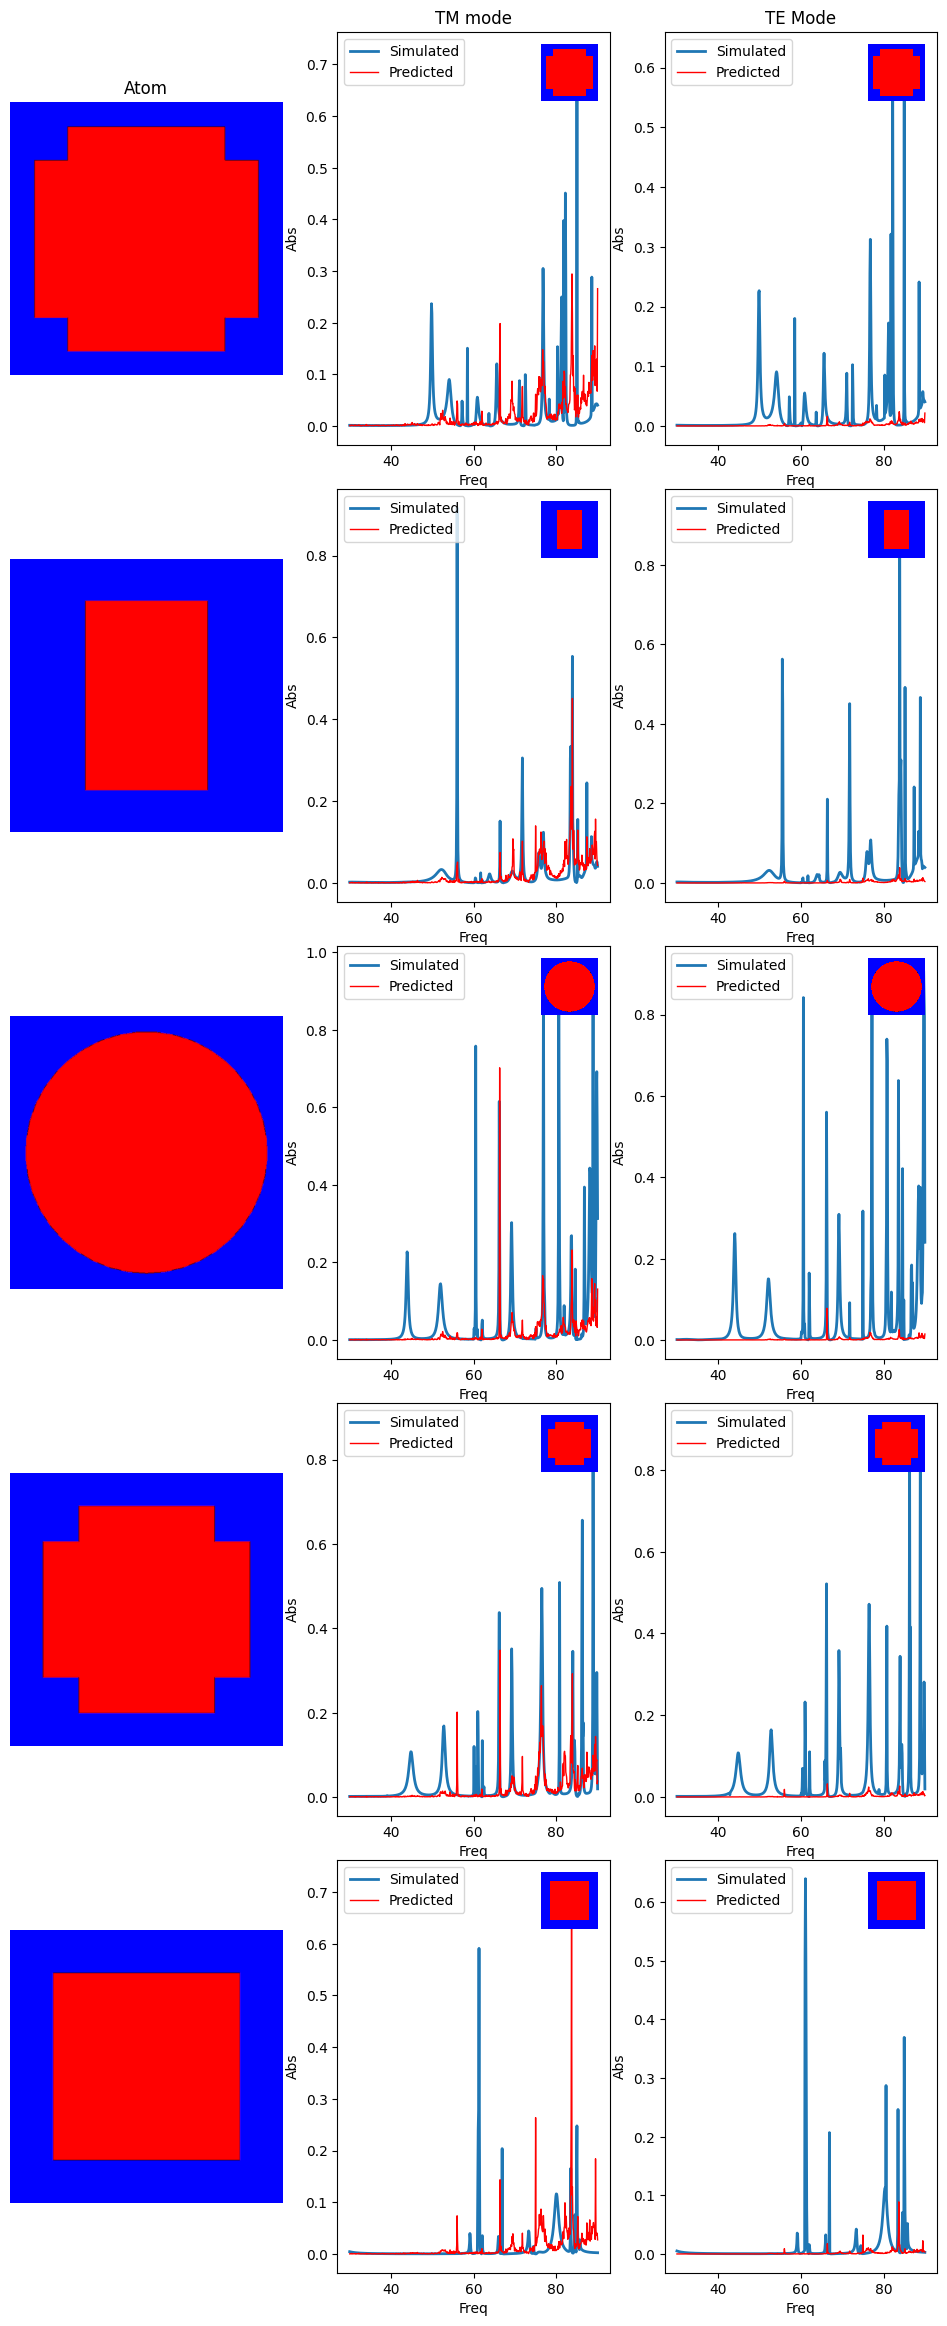

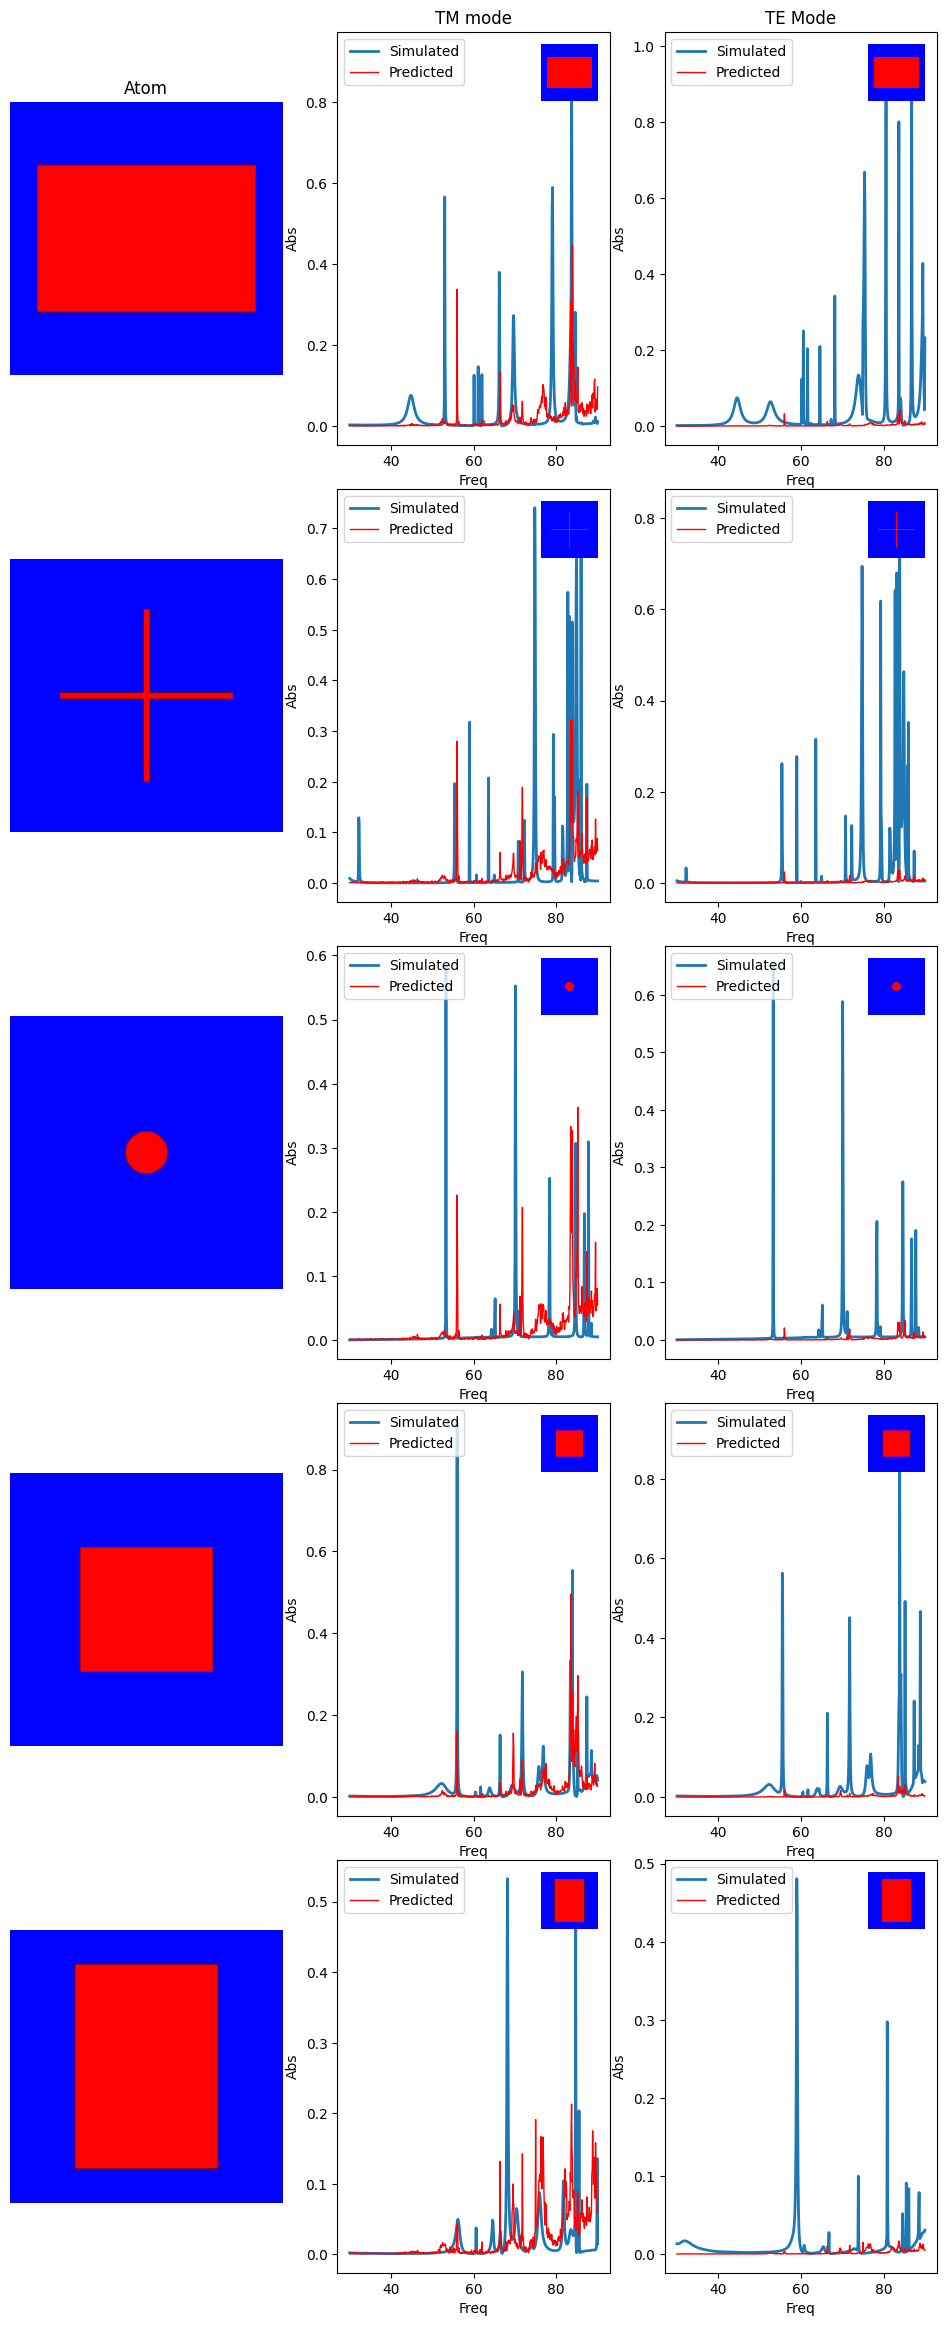

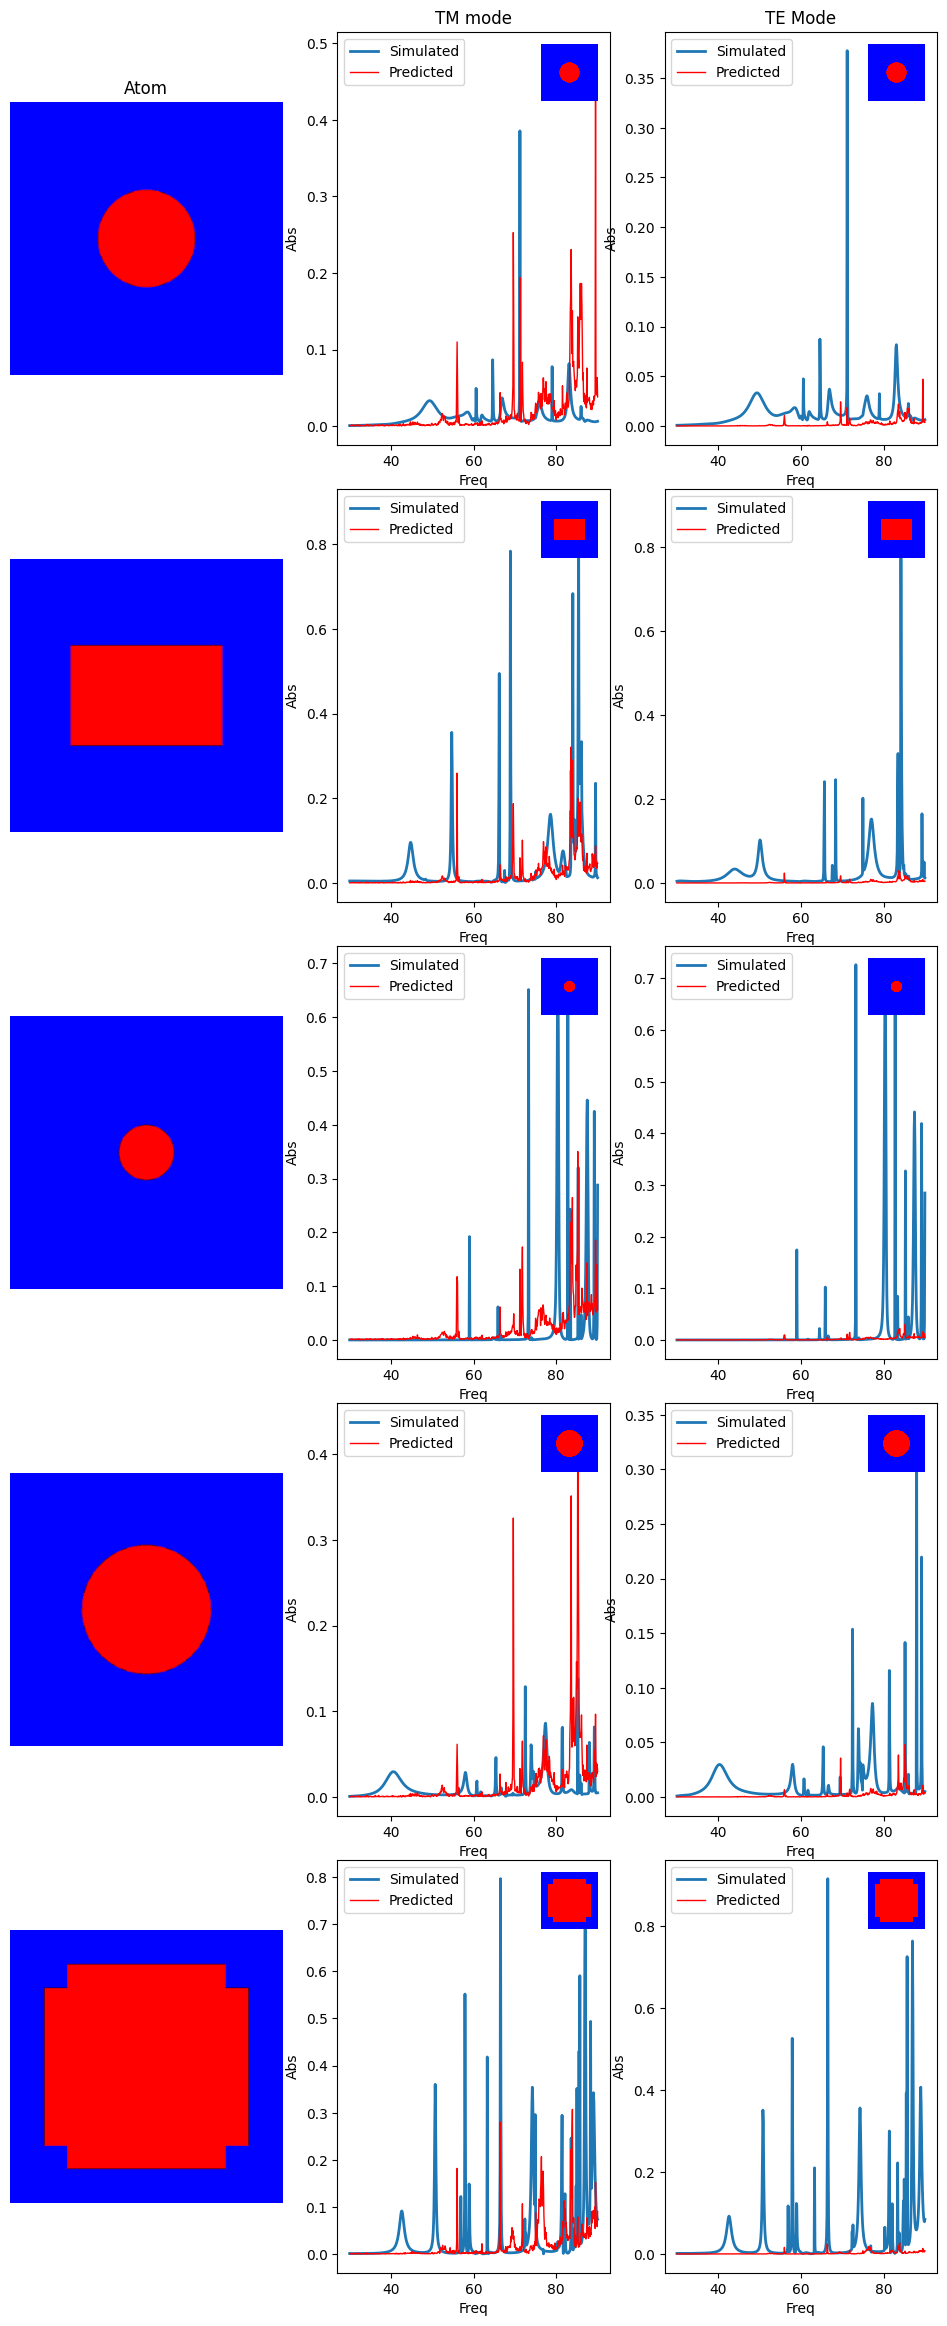

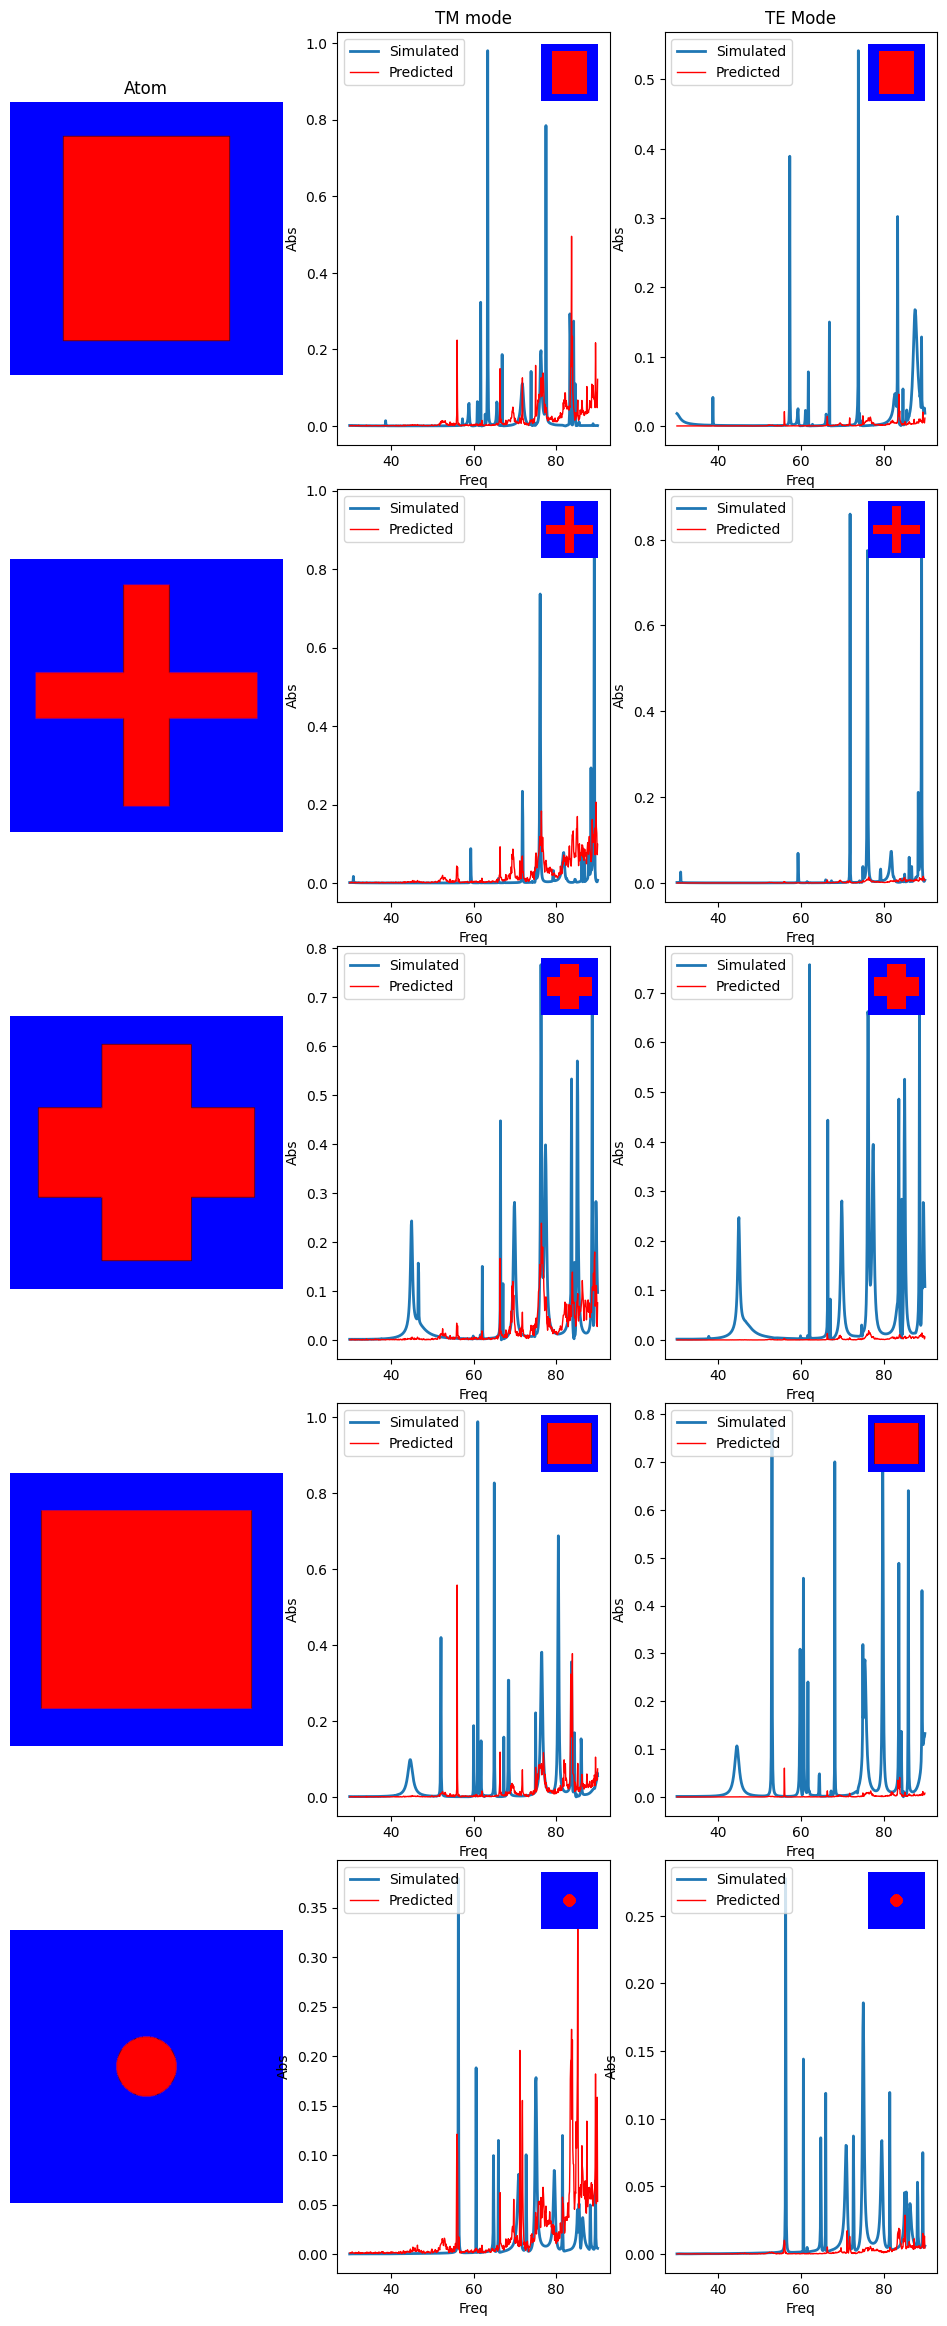

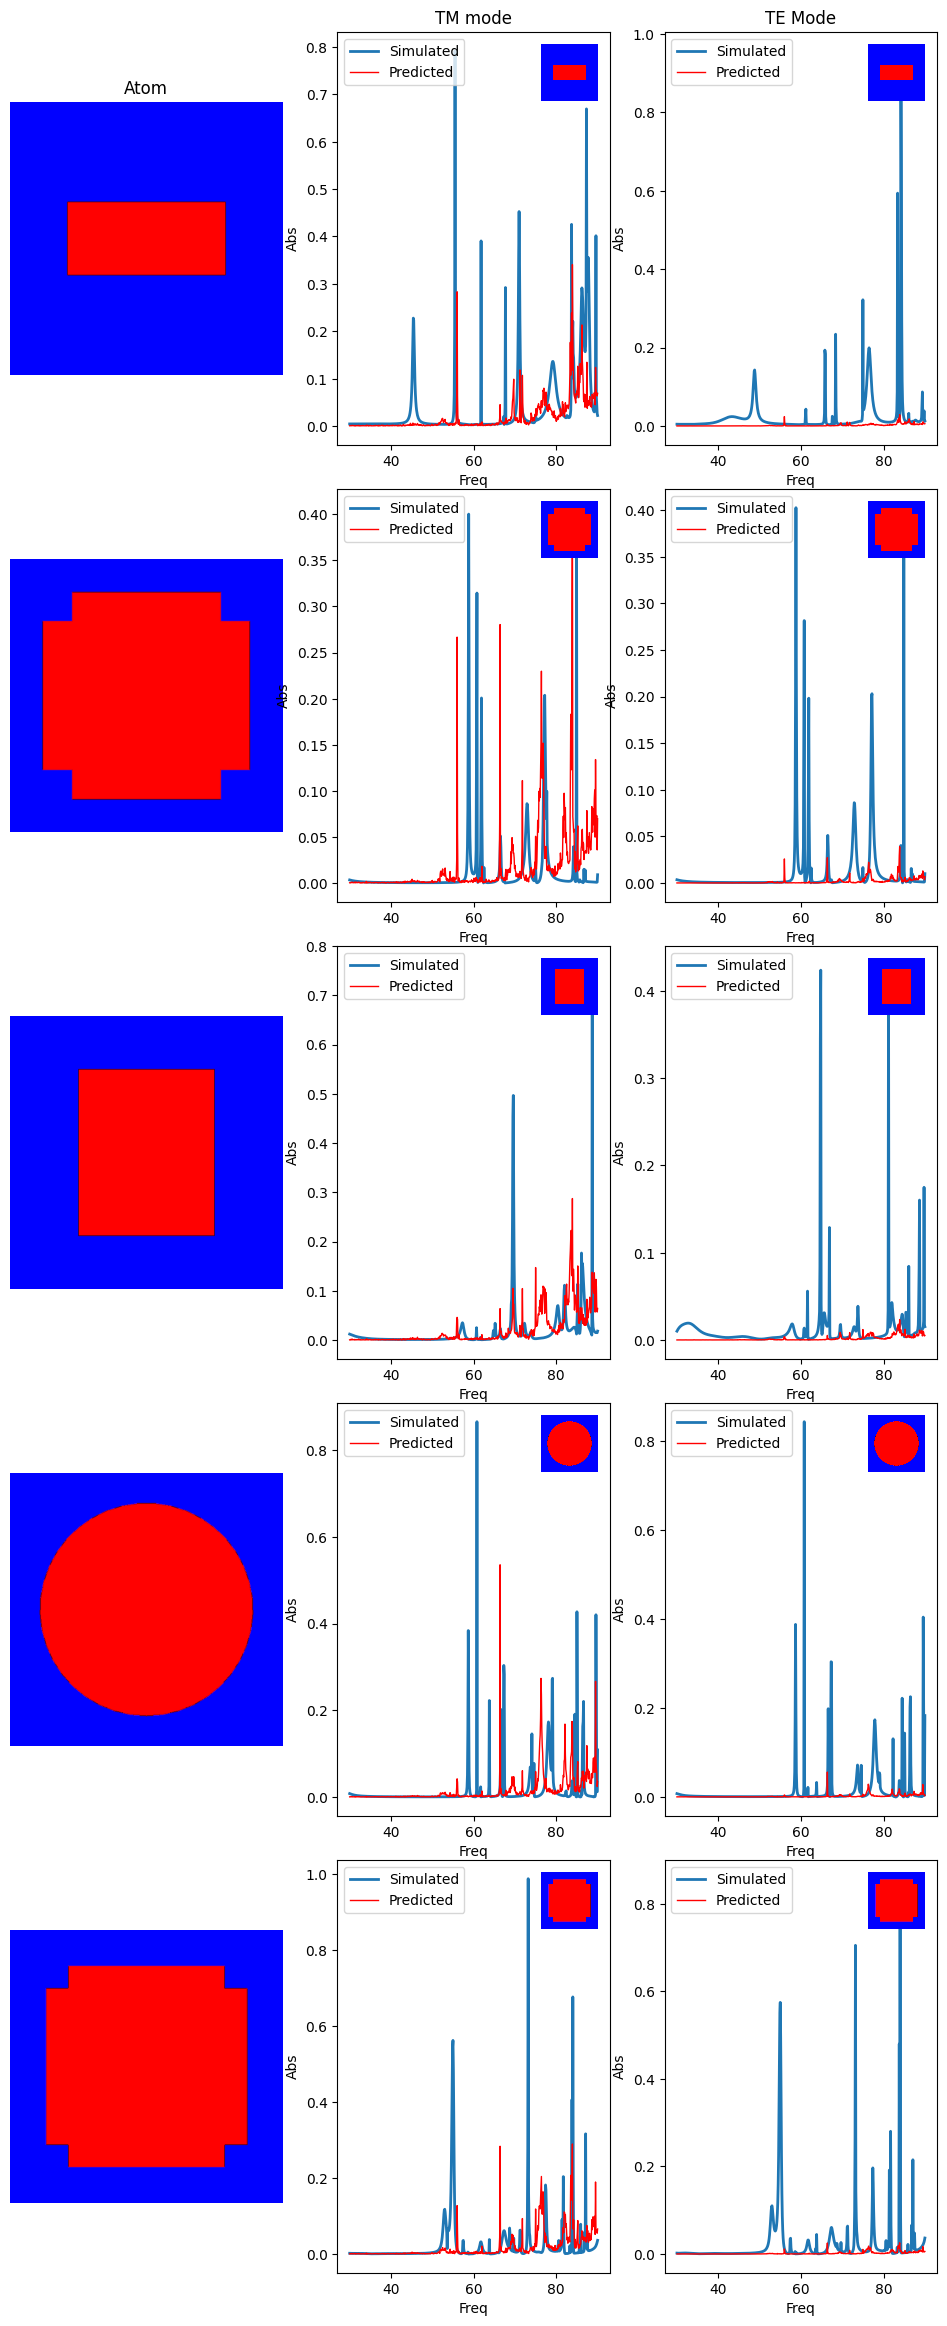

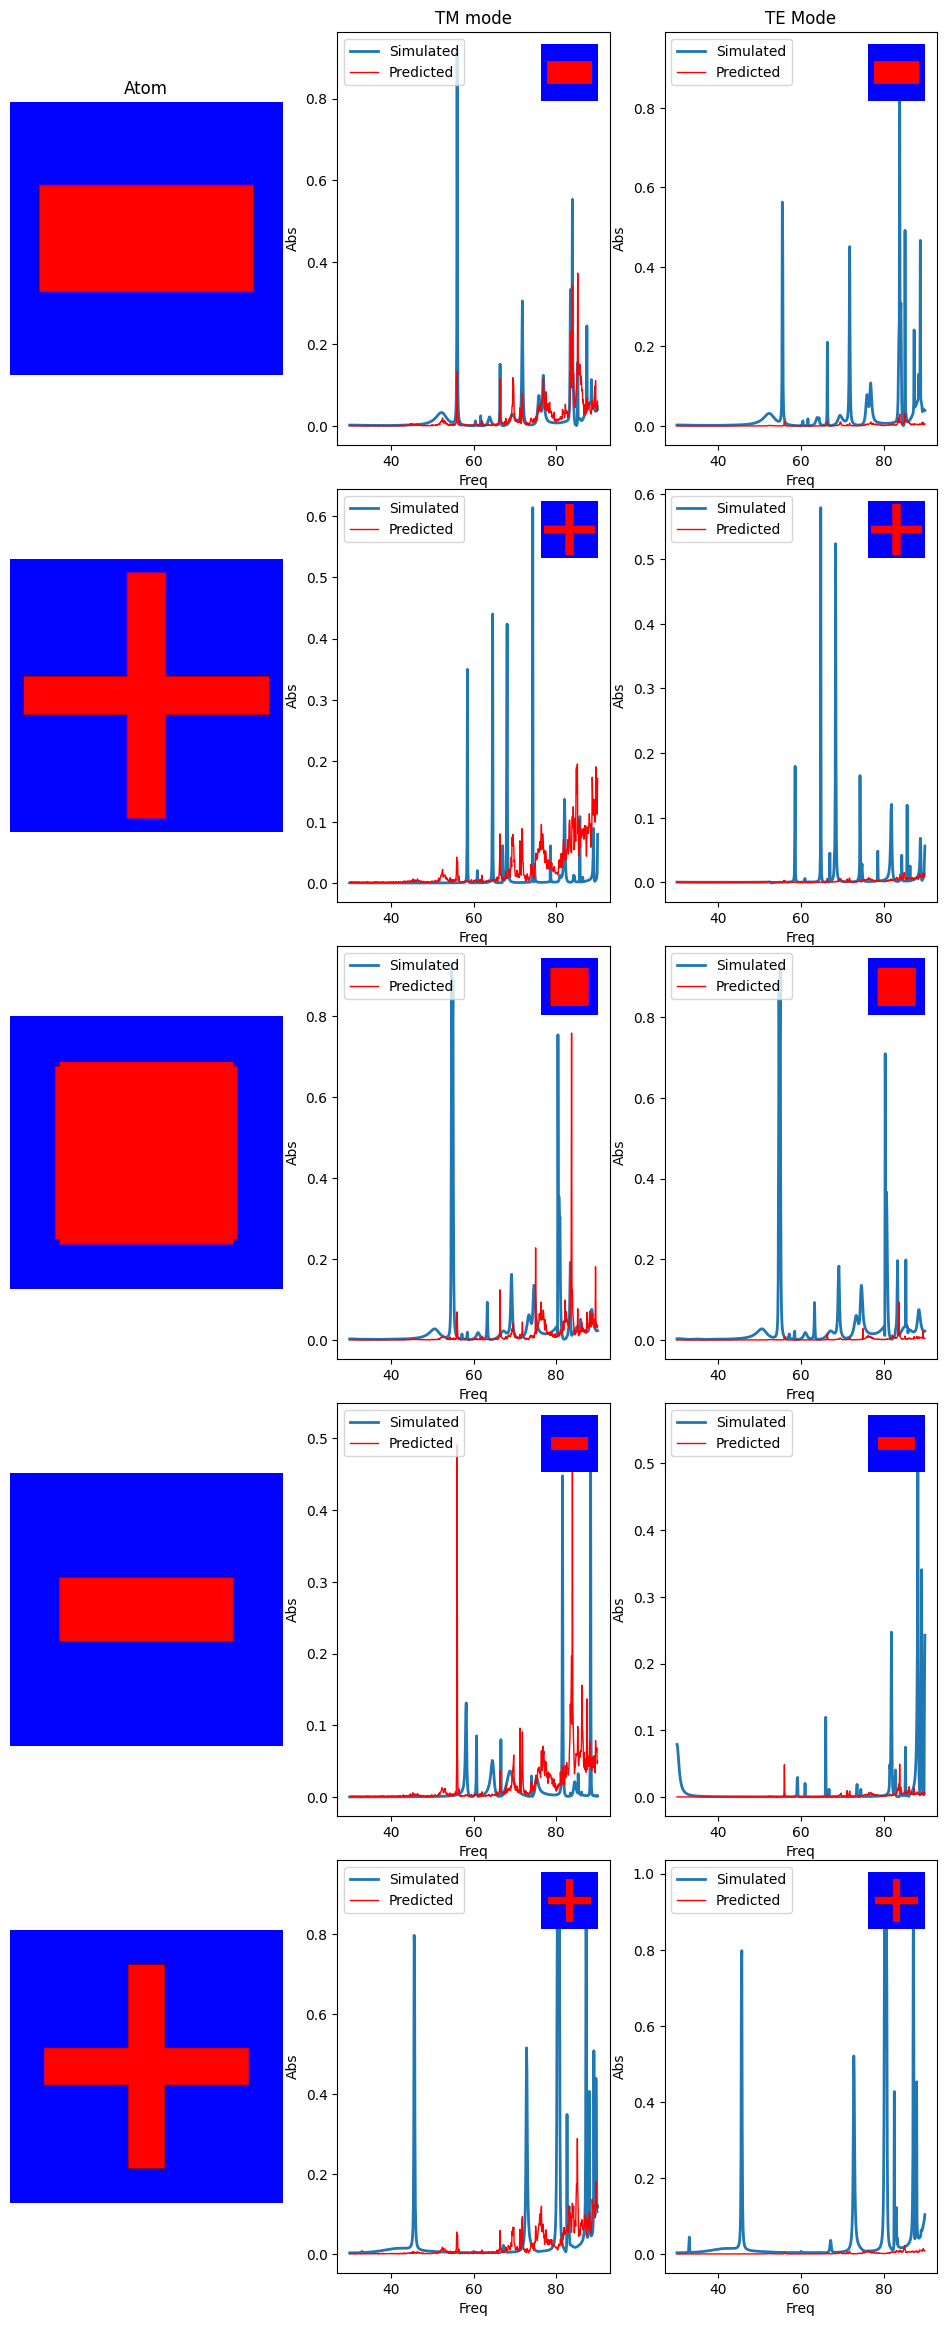

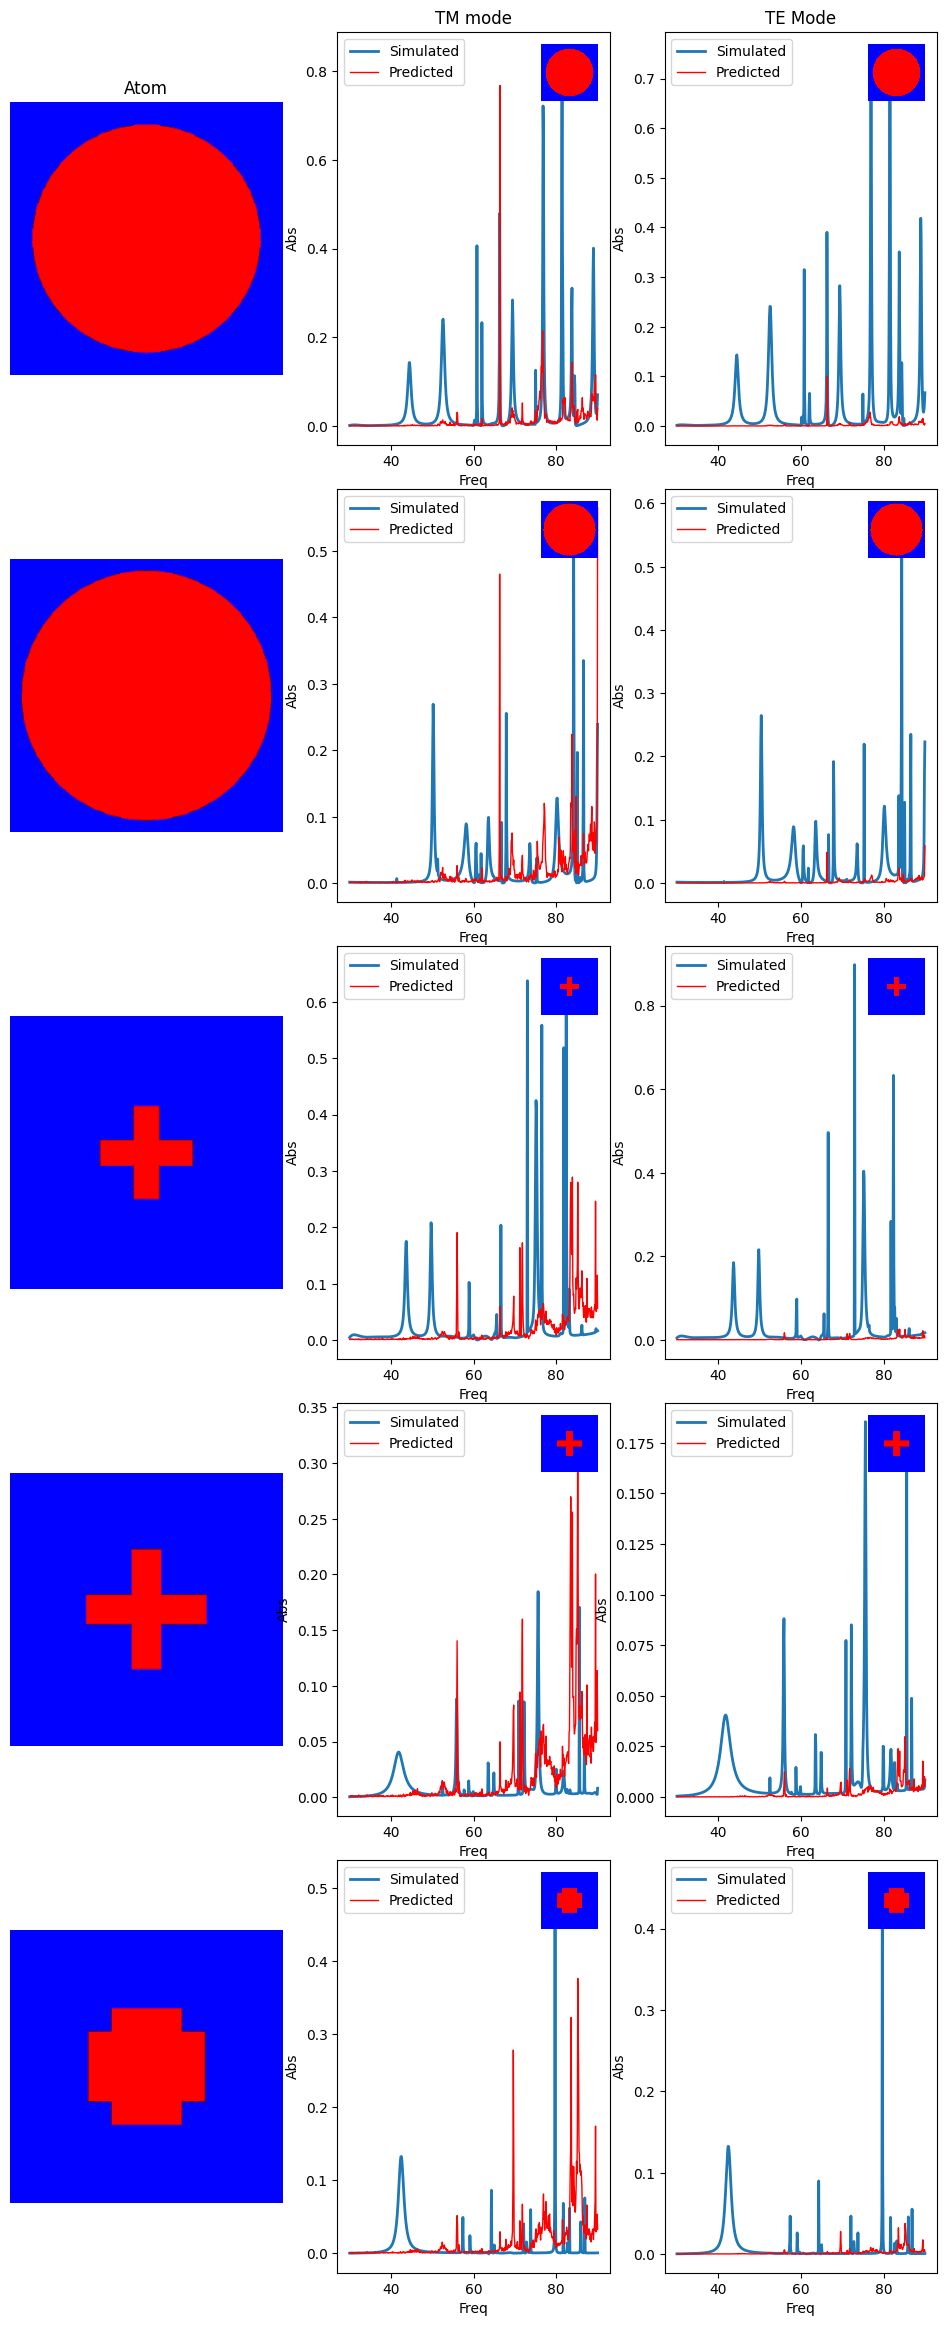

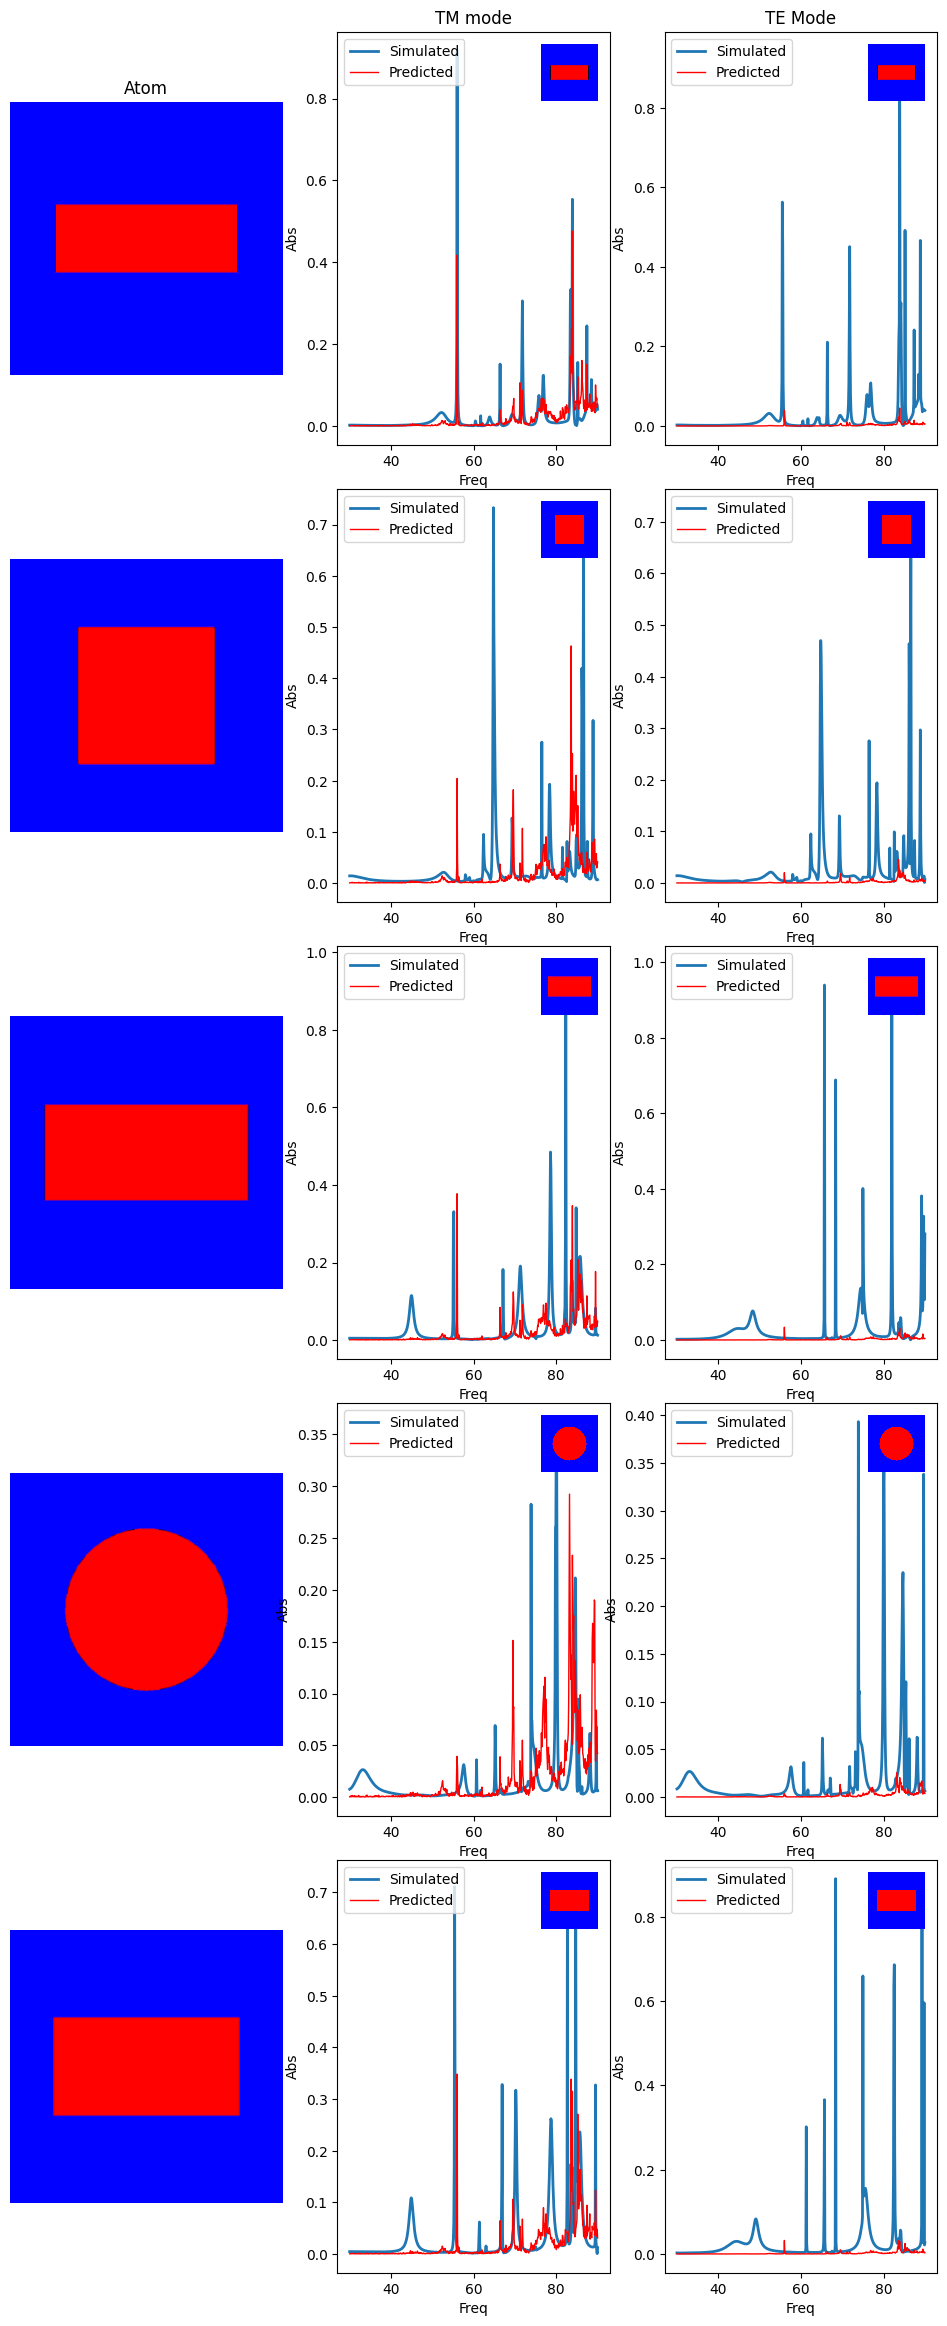

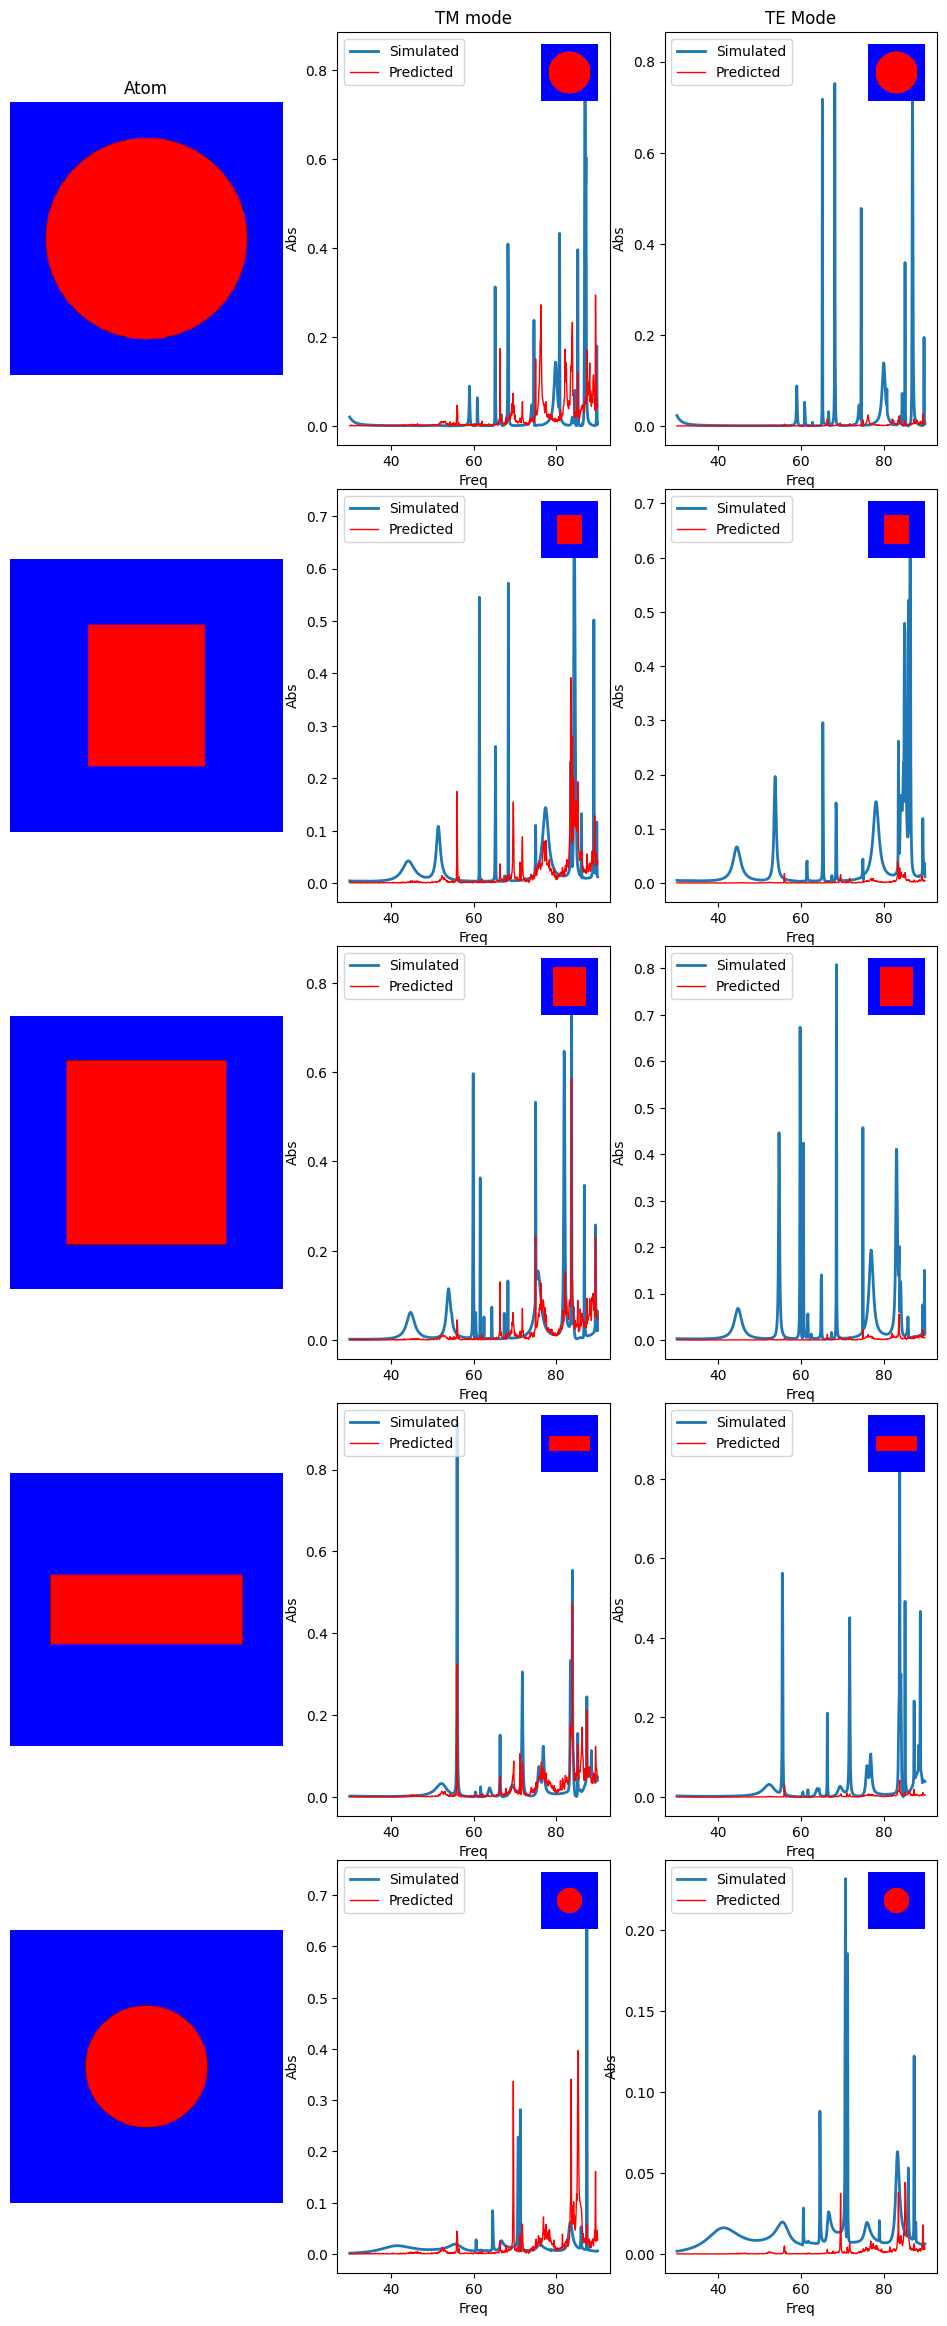

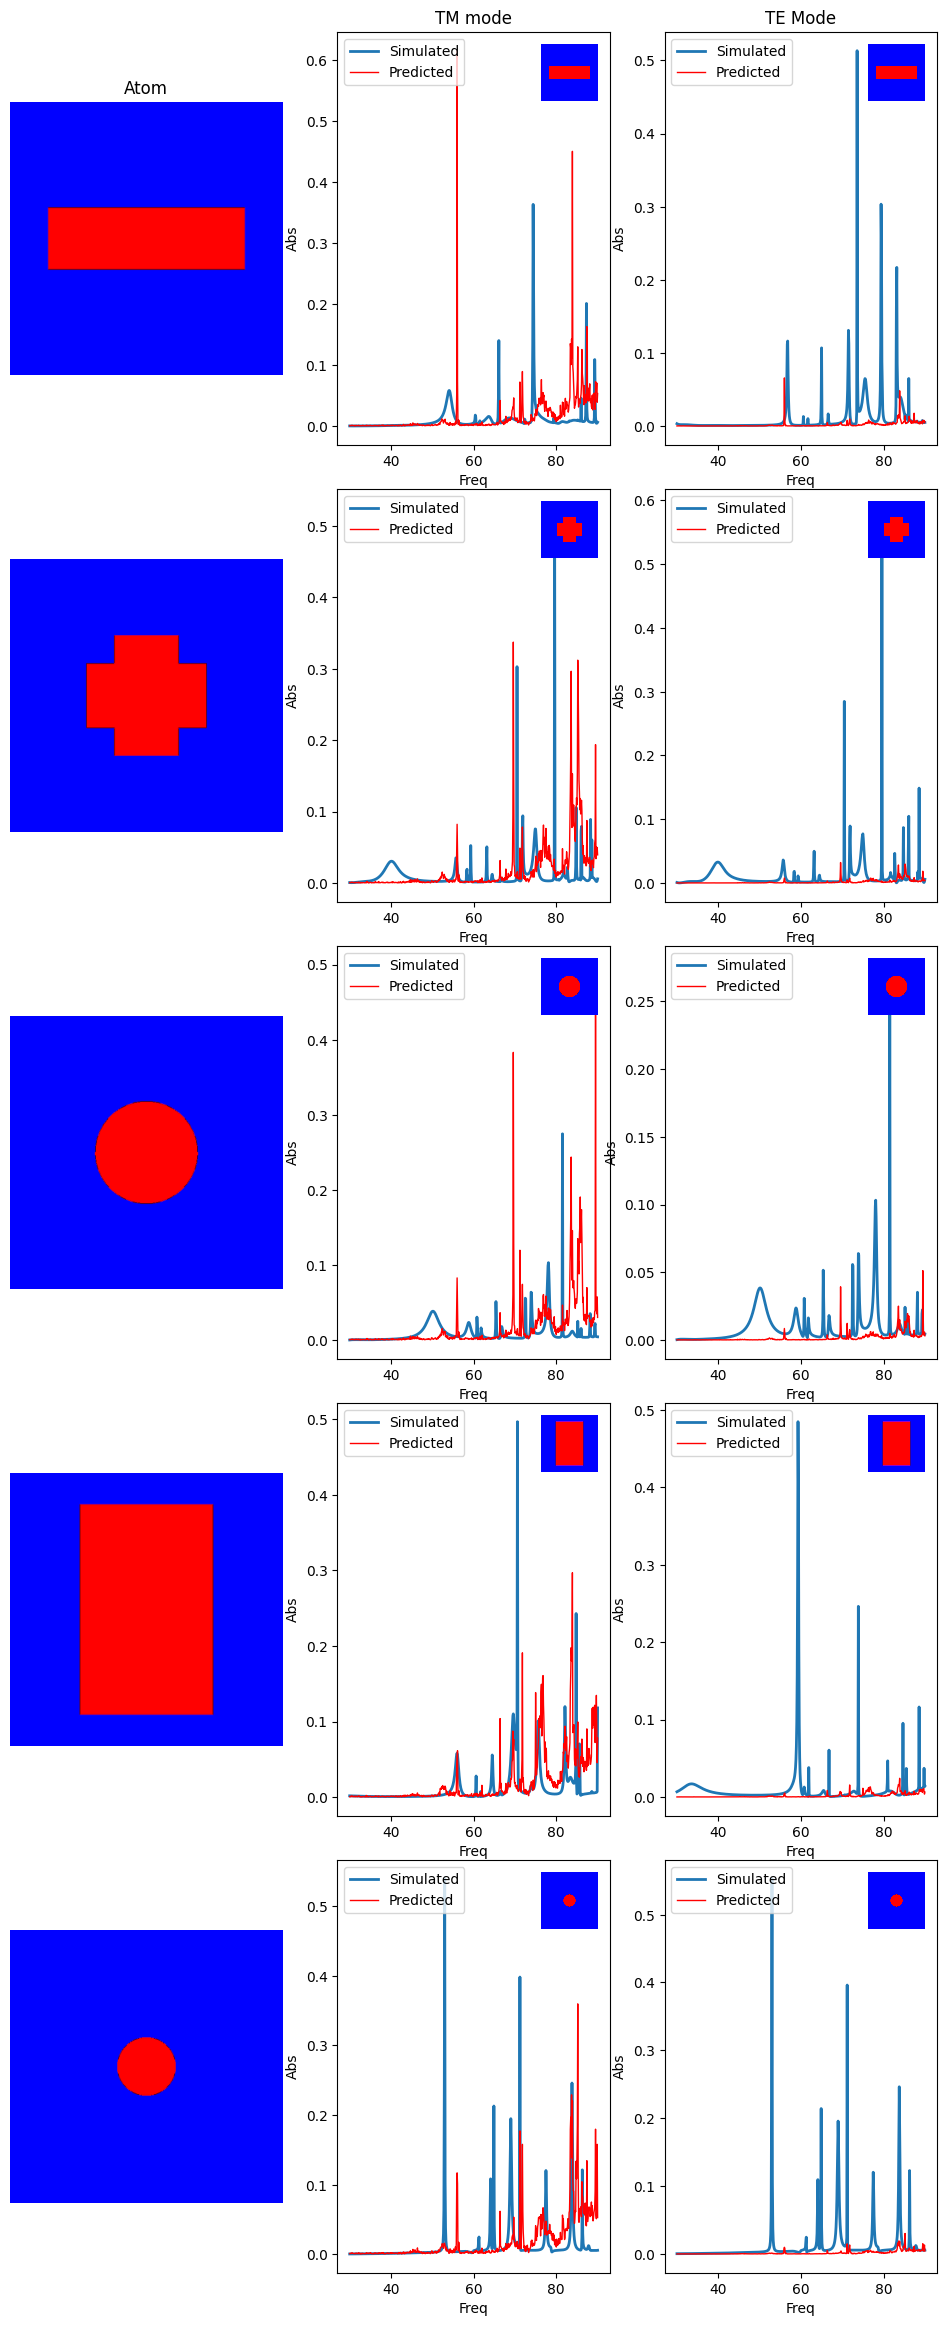

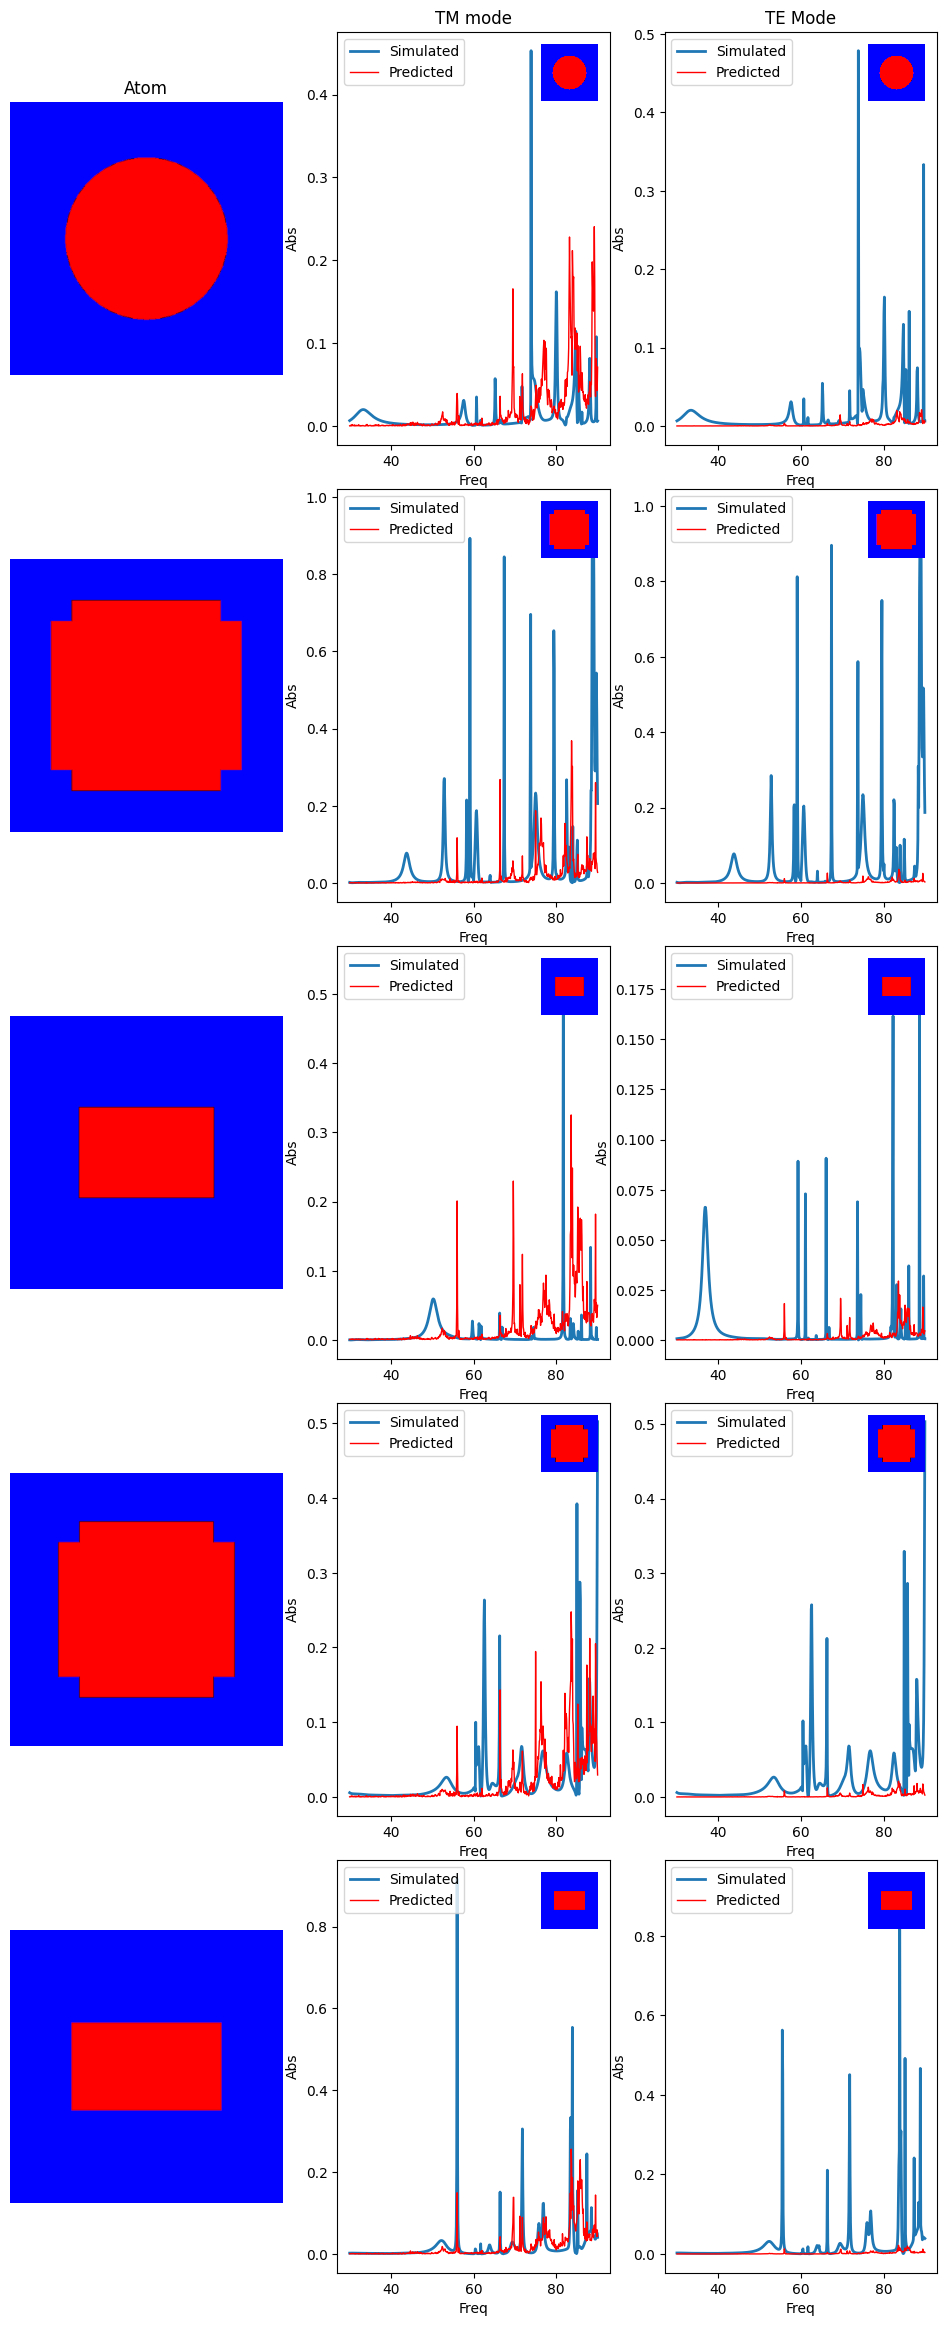

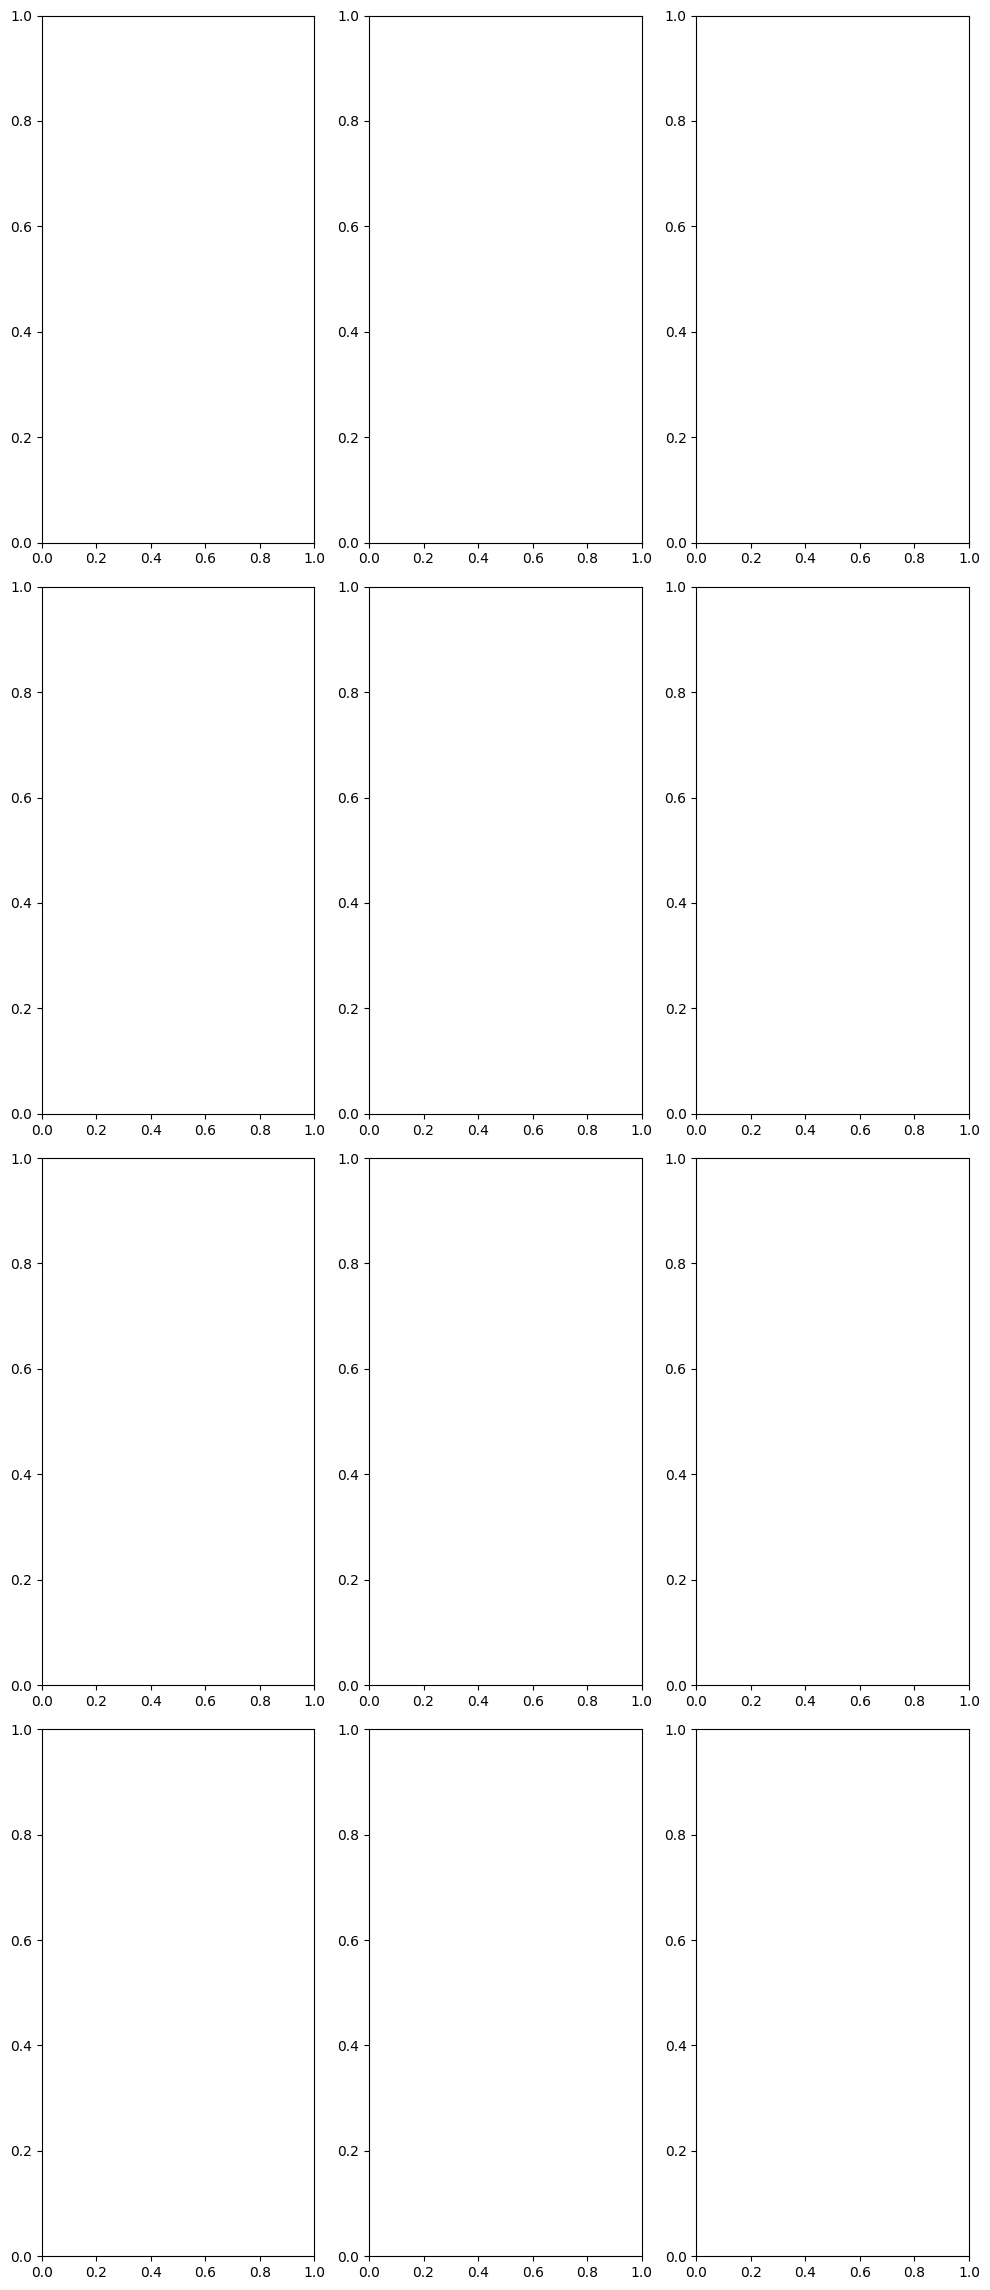

In [21]:
from scipy import signal
from scipy.signal import lfilter

output_test_TM=[]
output_test_TE=[]

for item in iter(dataloader_test):
    inputs,target,path, categories = item
    train=[]
    counter=0

    #figs
    fig, axs = plt.subplots(len(inputs),3,figsize=(10,23))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)

    #loop over test images names
    for name in path:
        series=name.split('_')[-1].split('.')[0]
        batch=name.split('_')[4]
        metricData=[]
        #loop over metric type -TM or TE
        for metric in metricType:
            
            #selecting data files depending on metric
            for name in glob(DataPath+batch+'\\files\\'+'/'+metric+'*'+series+'.csv'): 
                #loading the absorption data
                metricData.append(pd.read_csv(name))
        
        #every image data in array
        train.append(metricData)
        

    #conditioningArray=torch.FloatTensor(set_conditioning(target, path, categories))
    array, embedded=set_conditioning(target, path, categories)
    conditioningTensor = torch.nn.functional.normalize(embedded, p=2.0, dim = 1)

    #batch size
    output_test_TM=net_TM(input_=inputs, conditioning=conditioningTensor, b_size=inputs.shape[0])
    output_test_TM=torch.nn.functional.normalize(output_test_TM, p=2.0, dim = 1)

    output_test_TE=net_TE(input_=inputs, conditioning=conditioningTensor, b_size=inputs.shape[0])

    output_to_plot_TM=output_test_TM.cpu().detach().numpy()
    output_to_plot_TE=output_test_TE.cpu().detach().numpy()

    images_to_plot = inputs.detach().cpu().permute(0, 2, 3,1).numpy()
    
    cols=['Atom','TM mode', 'TE Mode']
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)

    
    #looop over every image data
    #[[freq TM][Freq TE]]
    for i,data in enumerate(train):
        
        x=np.array(data[0].values.T)[0] #frequency values
        
        #predicted TM and TE values 
        toPlot_TM=output_to_plot_TM[i]
        toPlot_TE=output_to_plot_TE[i]
  
        trueTM=np.array(data[0].values.T)[1]
        trueTE=np.array(data[1].values.T)[1]


        
        images = (images_to_plot[i] * 255).round().astype("uint8")
        pil_images = images

        axs[counter][0].imshow(pil_images)
        axs[counter][0].set_axis_off()
        
        axs[counter][1].plot(x,trueTM,label="Simulated",linewidth=2)
        axs[counter][1].plot(x,toPlot_TM,'r-',label="Predicted",linewidth=1)
        axs[counter][1].legend(loc="upper left")
        axs[counter, 1].set(xlabel='Freq', ylabel='Abs')
        #axs[counter, 1].set_ylim([0, 1])

        axs[counter][2].plot(x,trueTE,label="Simulated",linewidth=2)
        axs[counter][2].plot(x,toPlot_TE,'r-',label="Predicted",linewidth=1)
        axs[counter][2].legend(loc="upper left")
        axs[counter, 2].set(xlabel='Freq', ylabel='Abs')
        #axs[counter, 2].set_ylim([0, 1])
        
       
        imagebox = OffsetImage(images, zoom=1*0.08)
        imagebox2 = OffsetImage(images, zoom=1*0.08)

        ab = AnchoredOffsetbox(loc=1, child=imagebox, frameon=False)
        ab2 = AnchoredOffsetbox(loc=1, child=imagebox2, frameon=False)

        axs[counter][1].add_artist(ab)
        axs[counter][2].add_artist(ab2)
        
        counter=counter+1

  